In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Colab Notebooks'


Mounted at /content/drive
'Algorithm 01'			        naver_map_data_live.csv
'Algorithm 02.ipynb'		       'naver_map_data_live_modified (2).csv'
'Algorithm 03.ipynb'		        preprocessed_data.csv
 BreamAndSmelt.ipynb		        processed_data.csv
 Chapter2			        processed_data_menu.csv
'Chapter 3'			        processed_naver_map_data.csv
'Chapter 3-2 Linear Regression.ipynb'   processed_store_data.csv
'Chapter 3-3 Feature Engineering'       rating_median_filled.csv
'cleaned_data (1).csv'		        rating_taste_updated.csv
 cleaned_data.csv		        recrawl1.csv
'Copy of whisper-webui.ipynb'	        recrawl2.csv
 data_a.csv			        recrawl3.csv
 distance_applied.csv		        recrawl4.csv
 dontletthemknow.csv		        recrawl_data_1.csv
 final_data_1.csv		        recrawl_data_2.csv
 final_data_2_1.csv		        ReCrawl.ipynb
 final_data_2.csv		        re_crawl_menues.py
 final_data_3.csv		        RecrawlModeling.ipynb
 final_data.csv			        review_menu.csv
 KHUDA.ipynb			        X.csv


In [ ]:
# CSV 파일 불러오기
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/naver_map_data_live.csv')


# 쉼표 제거 및 소수/정수형 변환
df['rating'] = df['rating'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['visited_review'] = df['visited_review'].str.replace(',', '').str.extract('(\d+)').astype(int)
df['blog_review'] = df['blog_review'].str.replace(',', '').str.extract('(\d+)').astype(int)

# CSV 파일로 저장 (index는 필요 없으면 False)
df.to_csv('/content/drive/My Drive/Colab Notebooks/processed_naver_map_data.csv', index=True)



In [ ]:
processed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/processed_naver_map_data.csv')
one_hot = pd.read_csv('/content/drive/My Drive/Colab Notebooks/modified.csv')

processed = pd.merge(processed, one_hot[['category_group']], left_index=True, right_index=True)

# 로그 변환
processed['visited_review_log'] = np.log1p(processed['visited_review'])
processed['blog_review_log'] = np.log1p(df['blog_review'])
processed = processed.drop('category', axis=1)

print(processed.head(10))

processed.to_csv('/content/drive/My Drive/Colab Notebooks/processed_data.csv', index=False)

   Unnamed: 0    store_name  rating  visited_review  blog_review  \
0           0           포앤드    0.00            1144          619   
1           1       홍미집 영통점    0.00             556         1150   
2           2      창식당 영통역점    0.00             274         1170   
3           3            무릉    0.00             186           52   
4           4       수타원 영통점    4.38            1883         1741   
5           5           그로또    4.63            4353         1295   
6           6      썬프란시스코마켓    4.56            1093         1065   
7           7          카페서천    4.44             880         1150   
8           8    투파인드피터 영통점    0.00            2927         1656   
9           9  언양닭칼국수 수원영통점    0.00             613          113   

                                  address  taste_value  \
0                경기 수원시 영통구 청명남로 6 1층 포앤드        0.287   
1                 경기 수원시 영통구 청명남로 48-1 1층        0.290   
2  경기 수원시 영통구 청명남로28번길 20 플러스타운빌딩 1층 118호        0.329   
3                  

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rating_median_filled.csv')

import re

# 메뉴 컬럼을 문자열로 변환
df['menu'] = df['menu'].astype(str)

# 메뉴 컬럼에서 가격과 메뉴 이름 추출 함수
def extract_menu_items(menu_text):
    items = re.findall(r'메뉴:\s?(.*?), 가격:\s?([\d,]+)원', menu_text)
    return [(name.strip(), int(price.replace(',', ''))) for name, price in items]

# 각 행마다 중간 가격대 3개 선택
def get_middle_3_menus_filtered(row):
    items = extract_menu_items(row['menu'])
    if not items:
        return [None, None, None, None, None, None, None]

    # 카테고리 그룹이 6, 7이 아닐 경우 5000원 이하 메뉴 제거
    if row['category_group'] not in [6, 7]:
        items = [item for item in items if item[1] > 5000]

    if not items:
        return [None, None, None, None, None, None, None]

    items = sorted(items, key=lambda x: x[1])
    mid_index = len(items) // 2

    if len(items) >= 3:
        if len(items) % 2 == 1:
            selected = items[mid_index-1:mid_index+2]
        else:
            selected = items[mid_index-1:mid_index+2] if mid_index > 0 else items[:3]
    else:
        selected = items

    prices = [item[1] for item in selected]
    avg_price = sum(prices) / len(prices) if prices else None

    menu_names = [item[0] for item in selected]
    menu_prices = prices

    while len(menu_names) < 3:
        menu_names.append(None)
        menu_prices.append(None)

    return [menu_names[0], menu_prices[0], menu_names[1], menu_prices[1], menu_names[2], menu_prices[2], avg_price]

# 새 열 생성
df[['menu1', 'menu1_price', 'menu2', 'menu2_price', 'menu3', 'menu3_price', 'average_price']] = df.apply(get_middle_3_menus_filtered, axis=1, result_type='expand')

# CSV로 저장
df.to_csv('/content/drive/My Drive/Colab Notebooks/processed_store_data.csv', index=False)


In [ ]:
def calculate_average_price(row):
    prices = [row['menu1_price'], row['menu2_price'], row['menu3_price']]
    prices = [p for p in prices if pd.notnull(p)]  # None 값 제거

    if prices:
        return sum(prices) / len(prices)
    return None

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/processed_data_menu.csv')

# average_price 업데이트
df['average_price'] = df.apply(calculate_average_price, axis=1)
category = pd.read_csv('/content/drive/My Drive/Colab Notebooks/naver_map_data_live_modified (2).csv')

df = pd.merge(df, category[['category']], left_index=True, right_index=True)
print(df.head())

df.to_csv('/content/drive/My Drive/Colab Notebooks/processed_data_menu.csv', index=False)

   Unnamed: 0 store_name  rating  visited_review  blog_review  \
0           0        포앤드    4.46            1144          619   
1           1    홍미집 영통점    4.40             556         1150   
2           2   창식당 영통역점    4.40             274         1170   
3           3         무릉    4.44             186           52   
4           4    수타원 영통점    4.38            1883         1741   

                                  address  taste_value  \
0                경기 수원시 영통구 청명남로 6 1층 포앤드        0.287   
1                 경기 수원시 영통구 청명남로 48-1 1층        0.290   
2  경기 수원시 영통구 청명남로28번길 20 플러스타운빌딩 1층 118호        0.329   
3                    경기 수원시 영통구 반달로 30 2층        0.253   
4                  경기 수원시 영통구 봉영로1482번길 6        0.000   

                                                menu  category_group  \
0  메뉴: 양지쌀국수, 가격: 11,000원\n메뉴: 매운차돌쌀국수, 가격: 13,00...               5   
1  메뉴: 닭볶음탕(1인분), 가격: 12,900원\n메뉴: 투움바로제닭볶음탕(1인분)...               1   
2  메뉴: 창도리탕(곱창+대창+우삼겹)대표, 가격: 35,000원\n메뉴: 모

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/processed_data_menu.csv')
rating = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rating_taste_updated.csv')

df.update(rating[['taste_value']])
df.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv', index=False)

df = df.dropna(subset=['menu2'])
df = df[df['blog_review'] != 0]
df = df.set_index('Index')
df.to_csv('/content/drive/My Drive/Colab Notebooks/cleaned_data.csv', index=False)

print(df.count())
print(df.isnull().sum())
print(df.loc[(df['blog_review']==0), 'store_name'])
print((df == 0).sum())

store_name            280
category              280
category_group        280
rating                280
visited_review        280
blog_review           280
visited_review_log    280
blog_review_log       280
address               280
taste_value           280
menu1                 280
menu1_price           280
menu2                 280
menu2_price           280
menu3                 272
menu3_price           272
average_price         280
menu                  224
dtype: int64
store_name             0
category               0
category_group         0
rating                 0
visited_review         0
blog_review            0
visited_review_log     0
blog_review_log        0
address                0
taste_value            0
menu1                  0
menu1_price            0
menu2                  0
menu2_price            0
menu3                  8
menu3_price            8
average_price          0
menu                  56
dtype: int64
Series([], Name: store_name, dtype: object)
store_name  

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_data.csv')
#평점 받으면 그거 넣으면 됨

print(df.distance.head(100))

def convert_distance(val):
    try:
        # 문자열을 숫자로 변환
        num = float(val)
        if num > 100:
            return num / 1000  # 100으로 나누어 소수점 이하로 만듦
        else:
            return num
    except ValueError:
        # 변환 실패 시 기존 값 유지
        return val

df['distance'] = df['distance'].apply(convert_distance)

print(df.distance.max(),df.distance.min())
print(df.distance.head(100))



df['y'] = df[['target_a', 'target_b', 'target_c', 'target_d']].mean(axis=1, skipna=True)
print(df['y'].min(),df.y.max(),df.y.head(30))

#평점 결측치 있는지 확인해주기
print(df.isnull().sum())

#완성~~
df.to_csv('/content/drive/My Drive/Colab Notebooks/final_data.csv', index=False)

print(df.loc[df['menu'].isnull(), 'store_name'].reset_index(drop=True))



0     0.729
1     1.100
2     0.756
3     0.776
4     1.300
      ...  
95    1.000
96    0.969
97    0.993
98    0.497
99    0.995
Name: distance, Length: 100, dtype: float64
2.1 0.142
0     0.729
1     1.100
2     0.756
3     0.776
4     1.300
      ...  
95    1.000
96    0.969
97    0.993
98    0.497
99    0.995
Name: distance, Length: 100, dtype: float64
1.0 4.25 0     4.00
1     3.75
2     3.00
3     3.60
4     2.50
5     2.75
6     3.75
7     3.00
8     3.00
9     1.50
10    2.25
11    2.25
12    3.50
13    4.00
14    3.50
15    2.75
16    3.00
17    2.50
18    3.00
19    3.75
20    4.25
21    2.50
22    3.25
23    2.00
24    3.00
25    2.00
26    2.50
27    4.15
28    4.00
29    1.25
Name: y, dtype: float64
store_name              0
rating                  0
taste_value             0
distance                0
category                0
category_group          0
visited_review          0
blog_review             0
visited_review_log      0
blog_review_log         0
address        

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_data.csv')
import re

print(df.menu.isnull().sum())

def parse_menu(menu_text):
    # 입력이 문자열이 아닐 경우 None 반환 (NaN, float 등 방지)
    if not isinstance(menu_text, str):
        return None

    menu_dict = {}

    # 첫 번째 형태: "메뉴: 메뉴명, 가격: 가격원"
    pattern1 = r"메뉴:\s*(.*?),\s*가격:\s*([\d,]+)원"
    matches1 = re.findall(pattern1, menu_text)

    if matches1:
        for name, price in matches1:
            try:
                menu_dict[name.strip()] = int(price.replace(',', ''))
            except ValueError:
                return None  # 가격 변환이 안 되면 None 반환
        return menu_dict if menu_dict else None

    # 두 번째 형태: "메뉴명 : 가격원"
    pattern2 = r"(?:\[.*?\]\s*)?(.*?):\s*([\d,]+)(?:원)?"
    matches2 = re.findall(pattern2, menu_text)

    if matches2:
        for name, price in matches2:
            try:
                menu_dict[name.strip()] = int(price.replace(',', ''))
            except ValueError:
                return None  # 가격 변환이 안 되면 None 반환
        return menu_dict if menu_dict else None

    return None  # 둘 다 매칭되지 않으면 None 반환


df['menu_listed'] = df['menu'].apply(parse_menu)

print(df.dtypes)

df.to_csv('/content/drive/My Drive/Colab Notebooks/final_data_1.csv', index=False)

0
store_name             object
rating                float64
taste_value           float64
distance              float64
category               object
category_group          int64
visited_review          int64
blog_review             int64
visited_review_log    float64
blog_review_log       float64
address                object
menu1                  object
menu1_price             int64
menu2                  object
menu2_price             int64
menu3                  object
menu3_price           float64
average_price         float64
menu                   object
target_a              float64
target_b              float64
target_c              float64
target_d              float64
menu_listed            object
y                     float64
dtype: object


Index(['store_name', 'rating', 'taste_value', 'distance', 'category',
       'category_group', 'visited_review', 'blog_review', 'visited_review_log',
       'blog_review_log', 'address', 'menu1', 'menu1_price', 'menu2',
       'menu2_price', 'menu3', 'menu3_price', 'average_price', 'menu',
       'target_a', 'target_b', 'target_c', 'target_d', 'menu_listed', 'y',
       'rating_minmax', 'taste_value_minmax', 'y_minmax', 'average_price_log',
       'distance_log'],
      dtype='object')


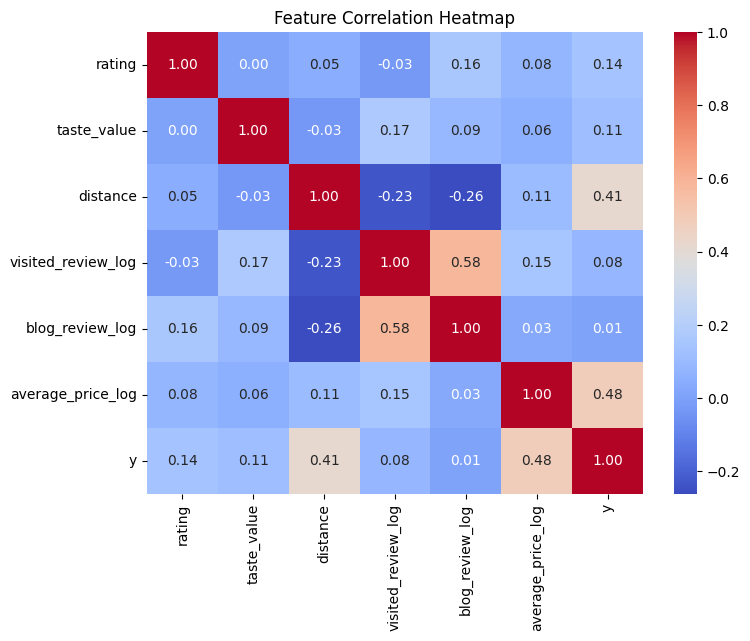

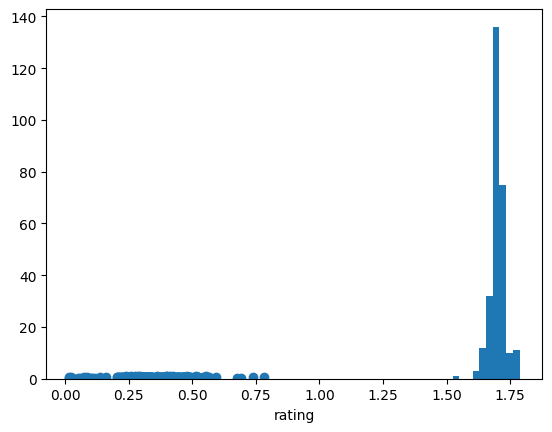

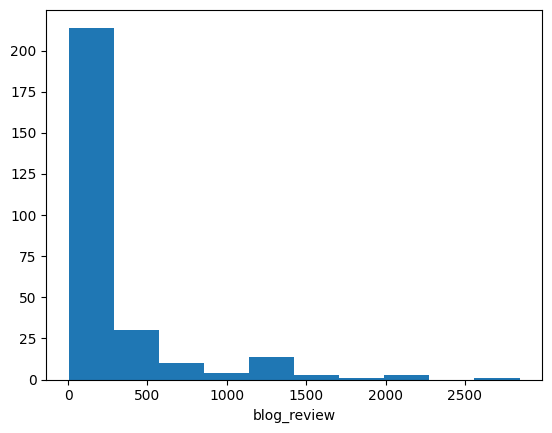

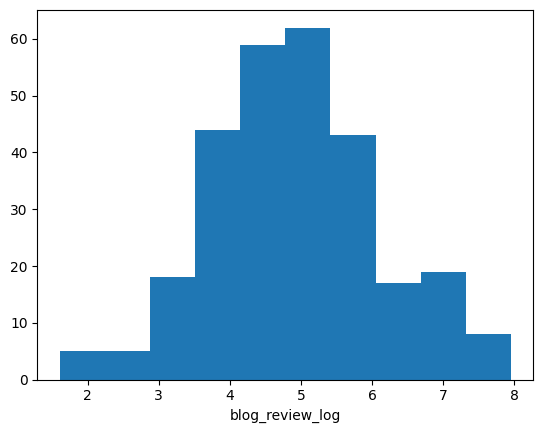

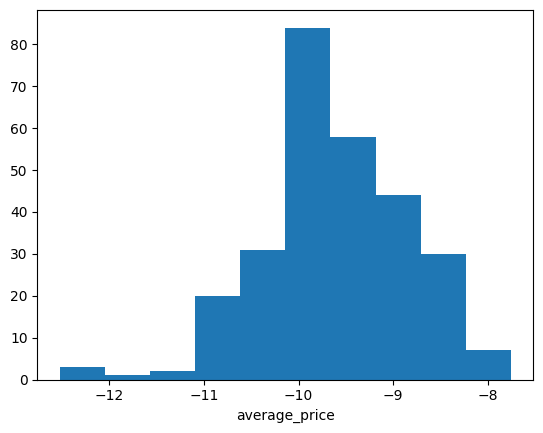

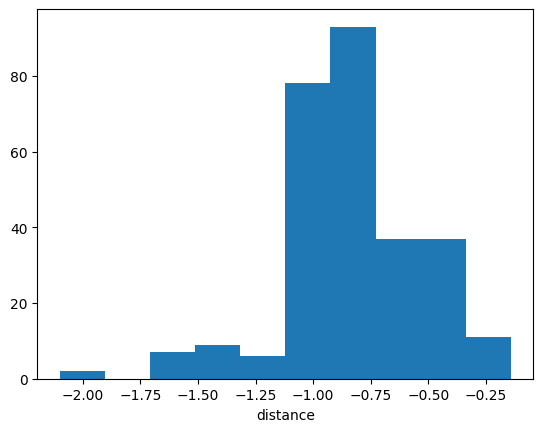

In [ ]:
#EDA begins..
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_data_1.csv')

scaler = MinMaxScaler()

df['rating_minmax']= scaler.fit_transform(df[['rating']])
df['taste_value_minmax'] = scaler.fit_transform(df[['taste_value']])
df['y_minmax'] = scaler.fit_transform(df[['y']])

df['average_price_log'] = np.log1p(df['average_price'])
df['distance_log'] = np.log1p(df['distance'])

df.columns

eda_columns = ['rating_minmax','taste_value_minmax','distance_log','visited_review_log','blog_review_log','average_price_log']
X = df[eda_columns]
y = df['y_minmax']

print(df.columns)

X.to_csv('/content/drive/My Drive/Colab Notebooks/X.csv', index=False)
y.to_csv('/content/drive/My Drive/Colab Notebooks/y.csv', index=False)

df.distance = df.distance*-1
df.average_price_log = df.average_price_log * -1

df['test1'] = df.visited_review_log * df.taste_value

eda_columns = ['rating','taste_value','distance','visited_review_log','blog_review_log','average_price_log','y']

corr_m = df[eda_columns].corr()
#corr_m = df[eda_columns].corr(method='spearman')  # 비선형 관계 고려
#corr_m = df[eda_columns].corr(method='kendall')   # 순위 기반 상관 분석


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_m, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#print(df.average_price.min())
plt.scatter(df.taste_value,y)
#plt.show()


plt.hist(df['blog_review'])
plt.xlabel('blog_review')
plt.show()
plt.hist(df['blog_review_log'])
plt.xlabel('blog_review_log')
plt.show()
plt.hist(df['average_price_log'])
plt.xlabel('average_price')
plt.show()
plt.hist(df['distance'])
plt.xlabel('distance')
plt.show()

0    {'양지쌀국수': 11000, '매운차돌쌀국수': 13000, '분짜': 15000...
1    {'닭볶음탕(1인분)': 12900, '투움바로제닭볶음탕(1인분)': 15500, ...
2    {'창도리탕(곱창+대창+우삼겹)대표': 35000, '모듬전골(곱창+대창+우삼겹)'...
3    {'히츠마부시': 30000, '히츠마부시(대)': 36000, '히츠마부시(특대)...
4    {'소갈비짬뽕': 16000, '해물짬뽕': 12000, '굴짬뽕': 11000, ...
Name: menu_listed, dtype: object
count       278.000000
mean      21460.251799
std       26252.550042
min        3000.000000
25%        9600.000000
50%       16000.000000
75%       24000.000000
max      275000.000000
Name: average_price, dtype: float64


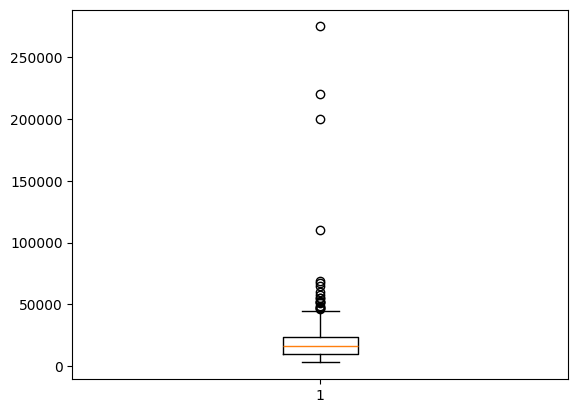

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_a.csv')
X_check = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_data_1.csv')

X_check['y'] = df['target_a']
print(X_check['menu_listed'].head())

import pandas as pd
import ast
from collections import Counter


import numpy as np


def calculate_median_price(menu_str, min_price):
    """최소 가격 이상인 메뉴들의 중앙값을 반환 (IQR 기반 이상치 제거)"""
    try:
        # 문자열을 딕셔너리로 변환
        menu_dict = ast.literal_eval(menu_str) if isinstance(menu_str, str) else menu_str
        if not isinstance(menu_dict, dict):
            return 0

        # 가격 필터링
        prices = [price for price in menu_dict.values() if price >= min_price]

        if not prices:
            return 0

        # IQR 계산
        q1 = np.percentile(prices, 0)
        q3 = np.percentile(prices, 75)
        iqr = q3 - q1

        # IQR을 이용한 필터링 (1.5 * IQR 밖의 값 제거)
        filtered_prices = [price for price in prices if (q1 - 1.5 * iqr) <= price <= (q3 + 1.5 * iqr)]
        #filtered_prices = [price for price in prices]
        return np.median(filtered_prices) if filtered_prices else np.median(prices)
    except (ValueError, SyntaxError):
        return 0

X_check['average_price'] = X_check.apply(
    lambda row: calculate_median_price(row['menu_listed'], 3000 if row['category_group'] in [6, 7] else 6000),
    axis=1
)



# 결과 확인
X_check.drop(X_check[X_check['average_price'] == 0].index, inplace=True)

print(X_check['average_price'].describe())

#print(X_check.store_name[X_check['average_price'] == 3000])
X_check.to_csv('/content/drive/My Drive/Colab Notebooks/final_data_3.csv', index=False)

import matplotlib.pyplot as plt
plt.boxplot(X_check['average_price'])
plt.show()